<a href="https://colab.research.google.com/github/bchoi2004/Advection-Equation-/blob/main/1D_Diffusion_Equation_Solver_TF_Edited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
my_dir = '/content/gdrive/My Drive/Spring_2024_DL/'

In [ ]:
# Set random seed for reproducibility
np.random.seed(1000)
tf.random.set_seed(1000)

alpha = 1


llim, tlim = 1, 1
Nx, Nt = 100, 100


x_np = np.linspace(0, llim, Nx)
t_np = np.linspace(0, tlim, Nt)

dx = llim / (Nx - 1)
dt = tlim / (Nt - 1)

X, T = np.meshgrid(x_np, t_np)
data = np.c_[X.ravel(), T.ravel()]

In [ ]:
# Model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(55, activation='swish', input_shape=(2,)),
    tf.keras.layers.Dense(55, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
def I(x):
    return tf.sin(np.pi * x)

# Custom loss function for the PDE
def custom_loss(x, t):

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])

        u_pred = model(tf.concat([x, t], axis=1), training=True)
        u_dx = tape.gradient(u_pred, x)
        u_dxx = tape.gradient(u_dx, x)
        u_dt = tape.gradient(u_pred, t)


        u_pred_t0 = model(tf.concat([x, tf.zeros_like(t)], axis=1), training=True)

        u_pred_x0 = model(tf.concat([tf.zeros_like(x), t], axis=1), training=True)
        u_pred_x1 = model(tf.concat([tf.ones_like(x), t], axis=1), training=True)


    loss_pde = tf.reduce_mean(tf.square(u_dt - alpha*u_dxx))
    loss_initial = tf.reduce_mean(tf.square(u_pred_t0 - I(x)))
    loss_bc_period = tf.reduce_mean(tf.square(u_pred_x0- u_pred_x1))
    loss_bc_x0 = tf.reduce_mean(tf.square(u_pred_x0 - 0))
    loss_bc_x1 = tf.reduce_mean(tf.square(u_pred_x1 - 0))

    total_loss = loss_pde + loss_initial + loss_bc_period + loss_bc_x0 + loss_bc_x1

    return total_loss

In [ ]:
# Training configuration
optimizer = tf.optimizers.Adam(learning_rate=0.01)
epochs = 300
batch_size = 1024

In [ ]:
# Training loop

for epoch in range(epochs):

    data_ = np.random.permutation(data)
    total_loss = 0
    num_batches = 0

    for i in range(0, data_.shape[0], batch_size):
        batch = data_[i:i + batch_size]
        x_batch, t_batch = [tf.convert_to_tensor(batch[:, j:j+1], dtype=tf.float32) for j in range(2)]

        with tf.GradientTape() as tape:
            loss = custom_loss(x_batch, t_batch)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        total_loss += loss.numpy()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f'Epoch {epoch + 1}, Average Loss: {average_loss}')


# Save the model
model.save(my_dir+'dnn_solver_1d_diffusion.h5')

Epoch 1, Average Loss: 0.08292458169162273
Epoch 2, Average Loss: 0.03762194328010082
Epoch 3, Average Loss: 0.02746458798646927
Epoch 4, Average Loss: 0.01888980735093355
Epoch 5, Average Loss: 0.01733870813623071
Epoch 6, Average Loss: 0.015326753351837396
Epoch 7, Average Loss: 0.01624775817617774
Epoch 8, Average Loss: 0.016821754071861504
Epoch 9, Average Loss: 0.01794266849756241
Epoch 10, Average Loss: 0.015989634953439236
Epoch 11, Average Loss: 0.017641740012913944
Epoch 12, Average Loss: 0.020888433791697025
Epoch 13, Average Loss: 0.02421515267342329
Epoch 14, Average Loss: 0.02214580662548542
Epoch 15, Average Loss: 0.01824252409860492
Epoch 16, Average Loss: 0.016928531136363743
Epoch 17, Average Loss: 0.021168756857514383
Epoch 18, Average Loss: 0.0165644402615726
Epoch 19, Average Loss: 0.015583195351064205
Epoch 20, Average Loss: 0.016166168823838235
Epoch 21, Average Loss: 0.019415522180497646
Epoch 22, Average Loss: 0.019250060617923736
Epoch 23, Average Loss: 0.01550

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 300, Average Loss: 0.01861416855826974


In [ ]:
# Load the model for test evaluation
loaded_model = tf.keras.models.load_model(my_dir+'dnn_solver_1d_diffusion.h5', compile=False)

### Define Analytical Solution

In [ ]:
def g(x, t):
    return np.exp(-np.pi**2 * t) * np.sin(np.pi * x)

### Model Prediction and Performance Analysis

In [ ]:
# Prediction and analysis
points_tf = tf.convert_to_tensor(data, dtype=tf.float32)
g_dnn = loaded_model(points_tf).numpy().flatten()

g_true = g(X.ravel(), T.ravel()).flatten()
diff = np.abs(g_true - g_dnn)
mse_dnn = np.mean(diff**2)

print(f'\nMax Absolute Error = {np.max(diff):.3f}')
print("Mean Squared Error = ", mse_dnn)


Max Absolute Error = 0.162
Mean Squared Error =  0.0014786393562429263


### Reshaping for grid visualization

In [ ]:
g_grid = g_true.reshape((Nt,Nx))
g_dnn_grid = g_dnn.reshape((Nt,Nx))
g_error_grid = (g_dnn_grid - g_grid)

### Contour plot of Analytical solution

<ipython-input-33-b37a2f28eb38>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


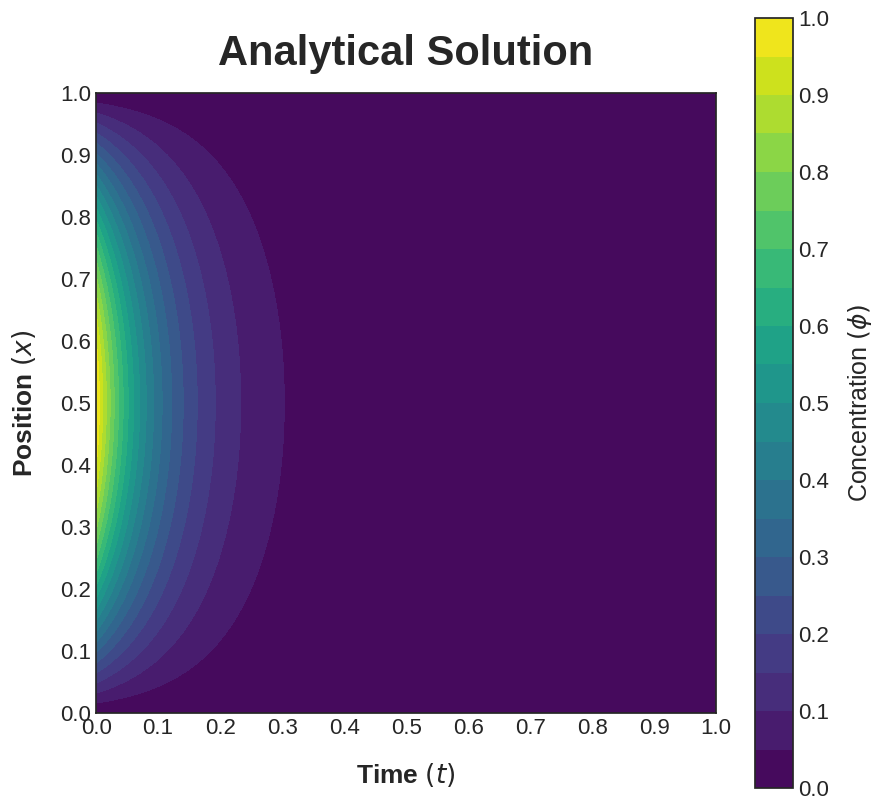

In [ ]:
cmap = plt.cm.viridis  #gist_earth
plt.style.use('seaborn-white')

fig1,ax = plt.subplots(figsize=(10,10))
ax.set_title('Analytical Solution', fontsize=30,fontweight='bold',pad=20)

levels = np.linspace(0,1,20+1)

ax.set_aspect('equal')
cf = ax.contourf(T, X, g_grid, cmap=cmap, levels=levels)

tick_values = np.arange(0, 1+0.0001, 0.1)
cbar = fig1.colorbar(cf, ax=ax, pad=0.05, ticks=tick_values)
cbar.set_label(r'Concentration $(\phi)$', labelpad=12, fontsize=18)
cbar.ax.tick_params(labelsize=16)

ax.set_xticks(np.arange(0,llim+0.0001,0.1))
ax.set_yticks(np.arange(0,tlim+0.0001,0.1))
ax.tick_params(axis='both', which='major', labelsize=16)

ax.set_xlabel('Time $(t)$',fontweight='bold', size=19,labelpad=16)
ax.set_ylabel('Position $(x)$',fontweight='bold', size=19,labelpad=16)
plt.show();

# plt.savefig(my_dir+'analytical_solution.png', format='png', dpi = 300)
# plt.close()

### Contour plot of DNN solution

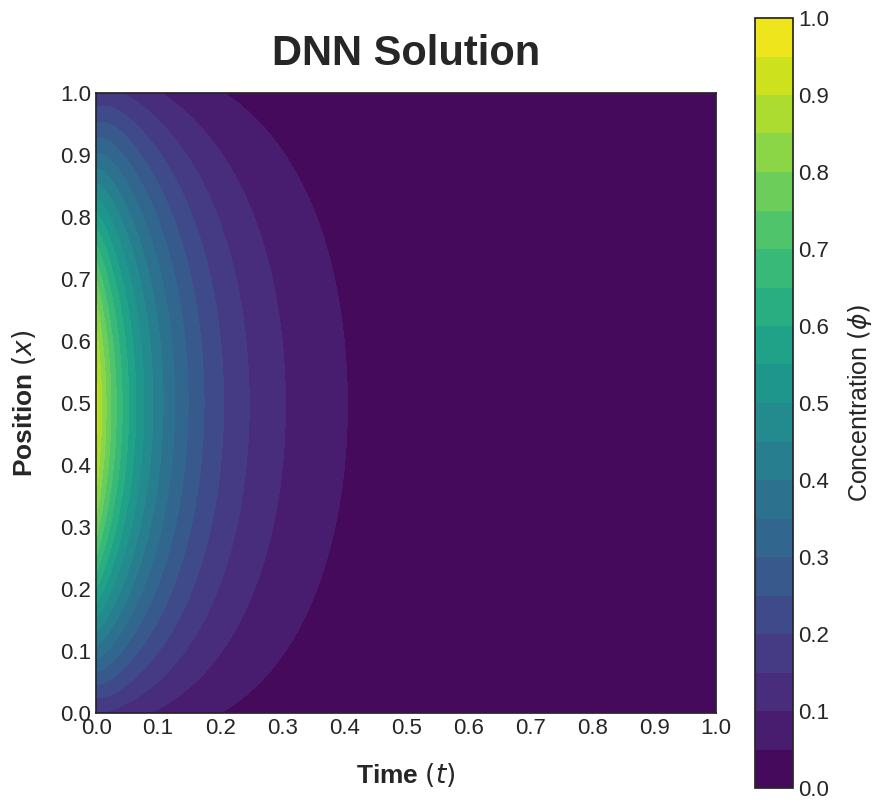

In [ ]:
fig2,ax = plt.subplots(figsize=(10,10))
ax.set_title('DNN Solution', fontsize=30,fontweight='bold',pad=20)
cmap = plt.cm.viridis

levels = np.linspace(0,1,20+1)

ax.set_aspect('equal')
cf = ax.contourf(T, X, g_dnn_grid, cmap=cmap, levels=levels)

tick_values = np.arange(0, 1+0.0001, 0.1)
cbar = fig2.colorbar(cf, ax=ax, pad=0.05, ticks=tick_values)
cbar.set_label(r'Concentration $(\phi)$', labelpad=12, fontsize=18)
cbar.ax.tick_params(labelsize=16)

ax.set_xticks(np.arange(0,llim+0.0001,0.1))
ax.set_yticks(np.arange(0,tlim+0.0001,0.1))
ax.tick_params(axis='both', which='major', labelsize=16)

ax.set_xlabel('Time $(t)$',fontweight='bold', size=19,labelpad=16)
ax.set_ylabel('Position $(x)$',fontweight='bold', size=19,labelpad=16)
plt.show();

# plt.savefig(my_dir+'dnn_solution.png', format='png', dpi = 300)
# plt.close()

### Error in Solution

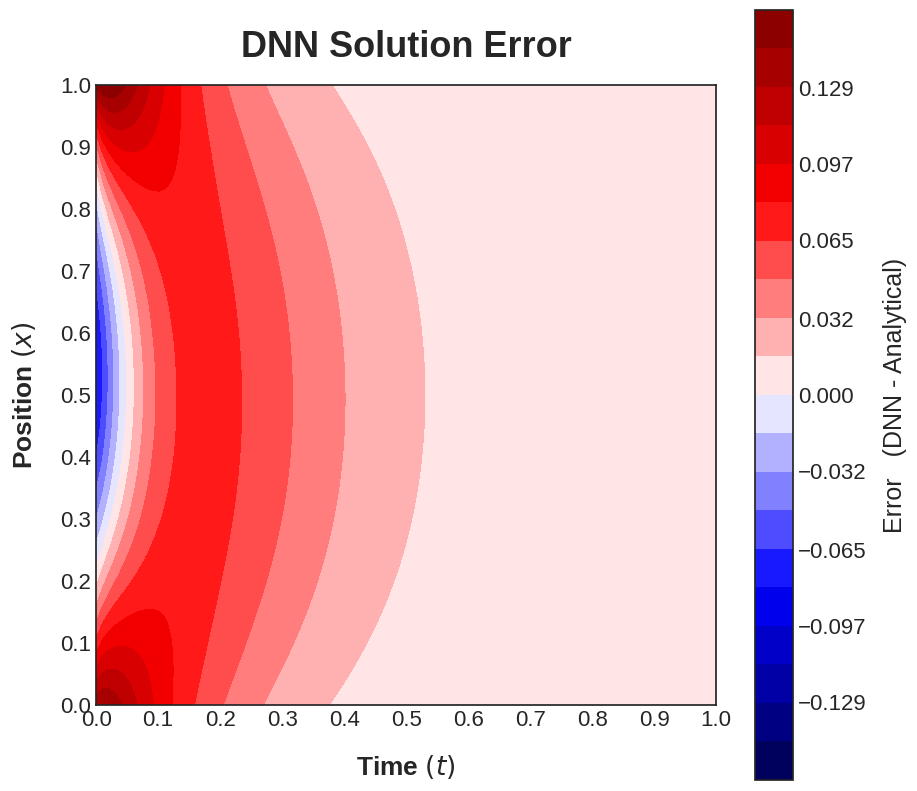

In [ ]:
fig3,ax = plt.subplots(figsize=(10,10))
ax.set_title('DNN Solution Error',fontsize=26,fontweight='bold',pad=20)
cmap = plt.cm.seismic

error_lim = np.max([abs(g_error_grid.min()), abs(g_error_grid.max())])

levels = np.linspace(-error_lim,error_lim,20+1)

ax.set_aspect('equal')
cf = ax.contourf(T, X, g_error_grid, cmap=cmap, levels=levels)

tick_values = np.around(np.linspace(-error_lim, error_lim, 10+1), decimals=3)
cbar = fig3.colorbar(cf, ax=ax, pad=0.05, ticks=tick_values)
cbar.set_label(r'Error   (DNN - Analytical)', labelpad=12, fontsize=18)
cbar.ax.tick_params(labelsize=16)

ax.set_xticks(np.arange(0,llim+0.0001,0.1))
ax.set_yticks(np.arange(0,tlim+0.0001,0.1))
ax.tick_params(axis='both', which='major', labelsize=16)

ax.set_xlabel('Time $(t)$',fontweight='bold', size=19,labelpad=16)
ax.set_ylabel('Position $(x)$',fontweight='bold', size=19,labelpad=16)
plt.show();

# plt.savefig(my_dir+'error_solution.png', format='png', dpi = 300)
# plt.close()

### Prepare GIF of Comparative Simulation

In [ ]:
from PIL import Image
import io


# Create a sequence of plots
time_interval = np.arange(0, tlim+0.0001, 0.05)  # From time 0 to 1 with dt = 0.05
frames = []  # List to hold individual frames

for t_step in time_interval:

    fig4, ax = plt.subplots(figsize=(10, 6))
    plt.style.use('seaborn-white')

    # Find the index corresponding to the current time step
    idx = np.argmin(np.abs(t_np - t_step))

    l1, = ax.plot(x_np, g_grid[idx, :], linewidth=0.9, alpha=0.8, color='blue', linestyle='-')
    l2, = ax.plot(x_np, g_dnn_grid[idx, :], linewidth=0.9, alpha=0.8, color='red', linestyle='-.')

    ax.set_xticks(np.arange(0,llim+0.0001,0.1))
    ax.set_yticks(np.arange(0,1+0.0001,0.1))
    ax.tick_params(axis='both', which='major', labelsize=14)

    ax.set_title(f'Solution at time: {t_step:.2f}', fontweight='bold', fontsize=24)
    ax.set_xlabel('Position $(x)$', fontweight='bold', size=16, labelpad=15)
    ax.set_ylabel(r'Concentration $(\phi)$', fontweight='bold', size=16, labelpad=16)

    ax.legend((l1, l2), ('Analytical', 'DNN'), loc='upper right', fontsize=14)

    # Convert plot to image and add to frames
    buf = io.BytesIO()  #Allocate temporary storage for in-memory stream
    plt.savefig(buf, format='png', dpi = 300)
    buf.seek(0)
    frame = Image.open(buf)
    frames.append(frame)
    plt.close()

# Create the GIF
frames[0].save(my_dir+'diffusion_simulation.gif', format='GIF', append_images=frames[1:], save_all=True, duration=550, loop=0)

<ipython-input-36-ca06a4561372>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')
<ipython-input-36-ca06a4561372>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')
<ipython-input-36-ca06a4561372>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead

### Display the Simulation GIF

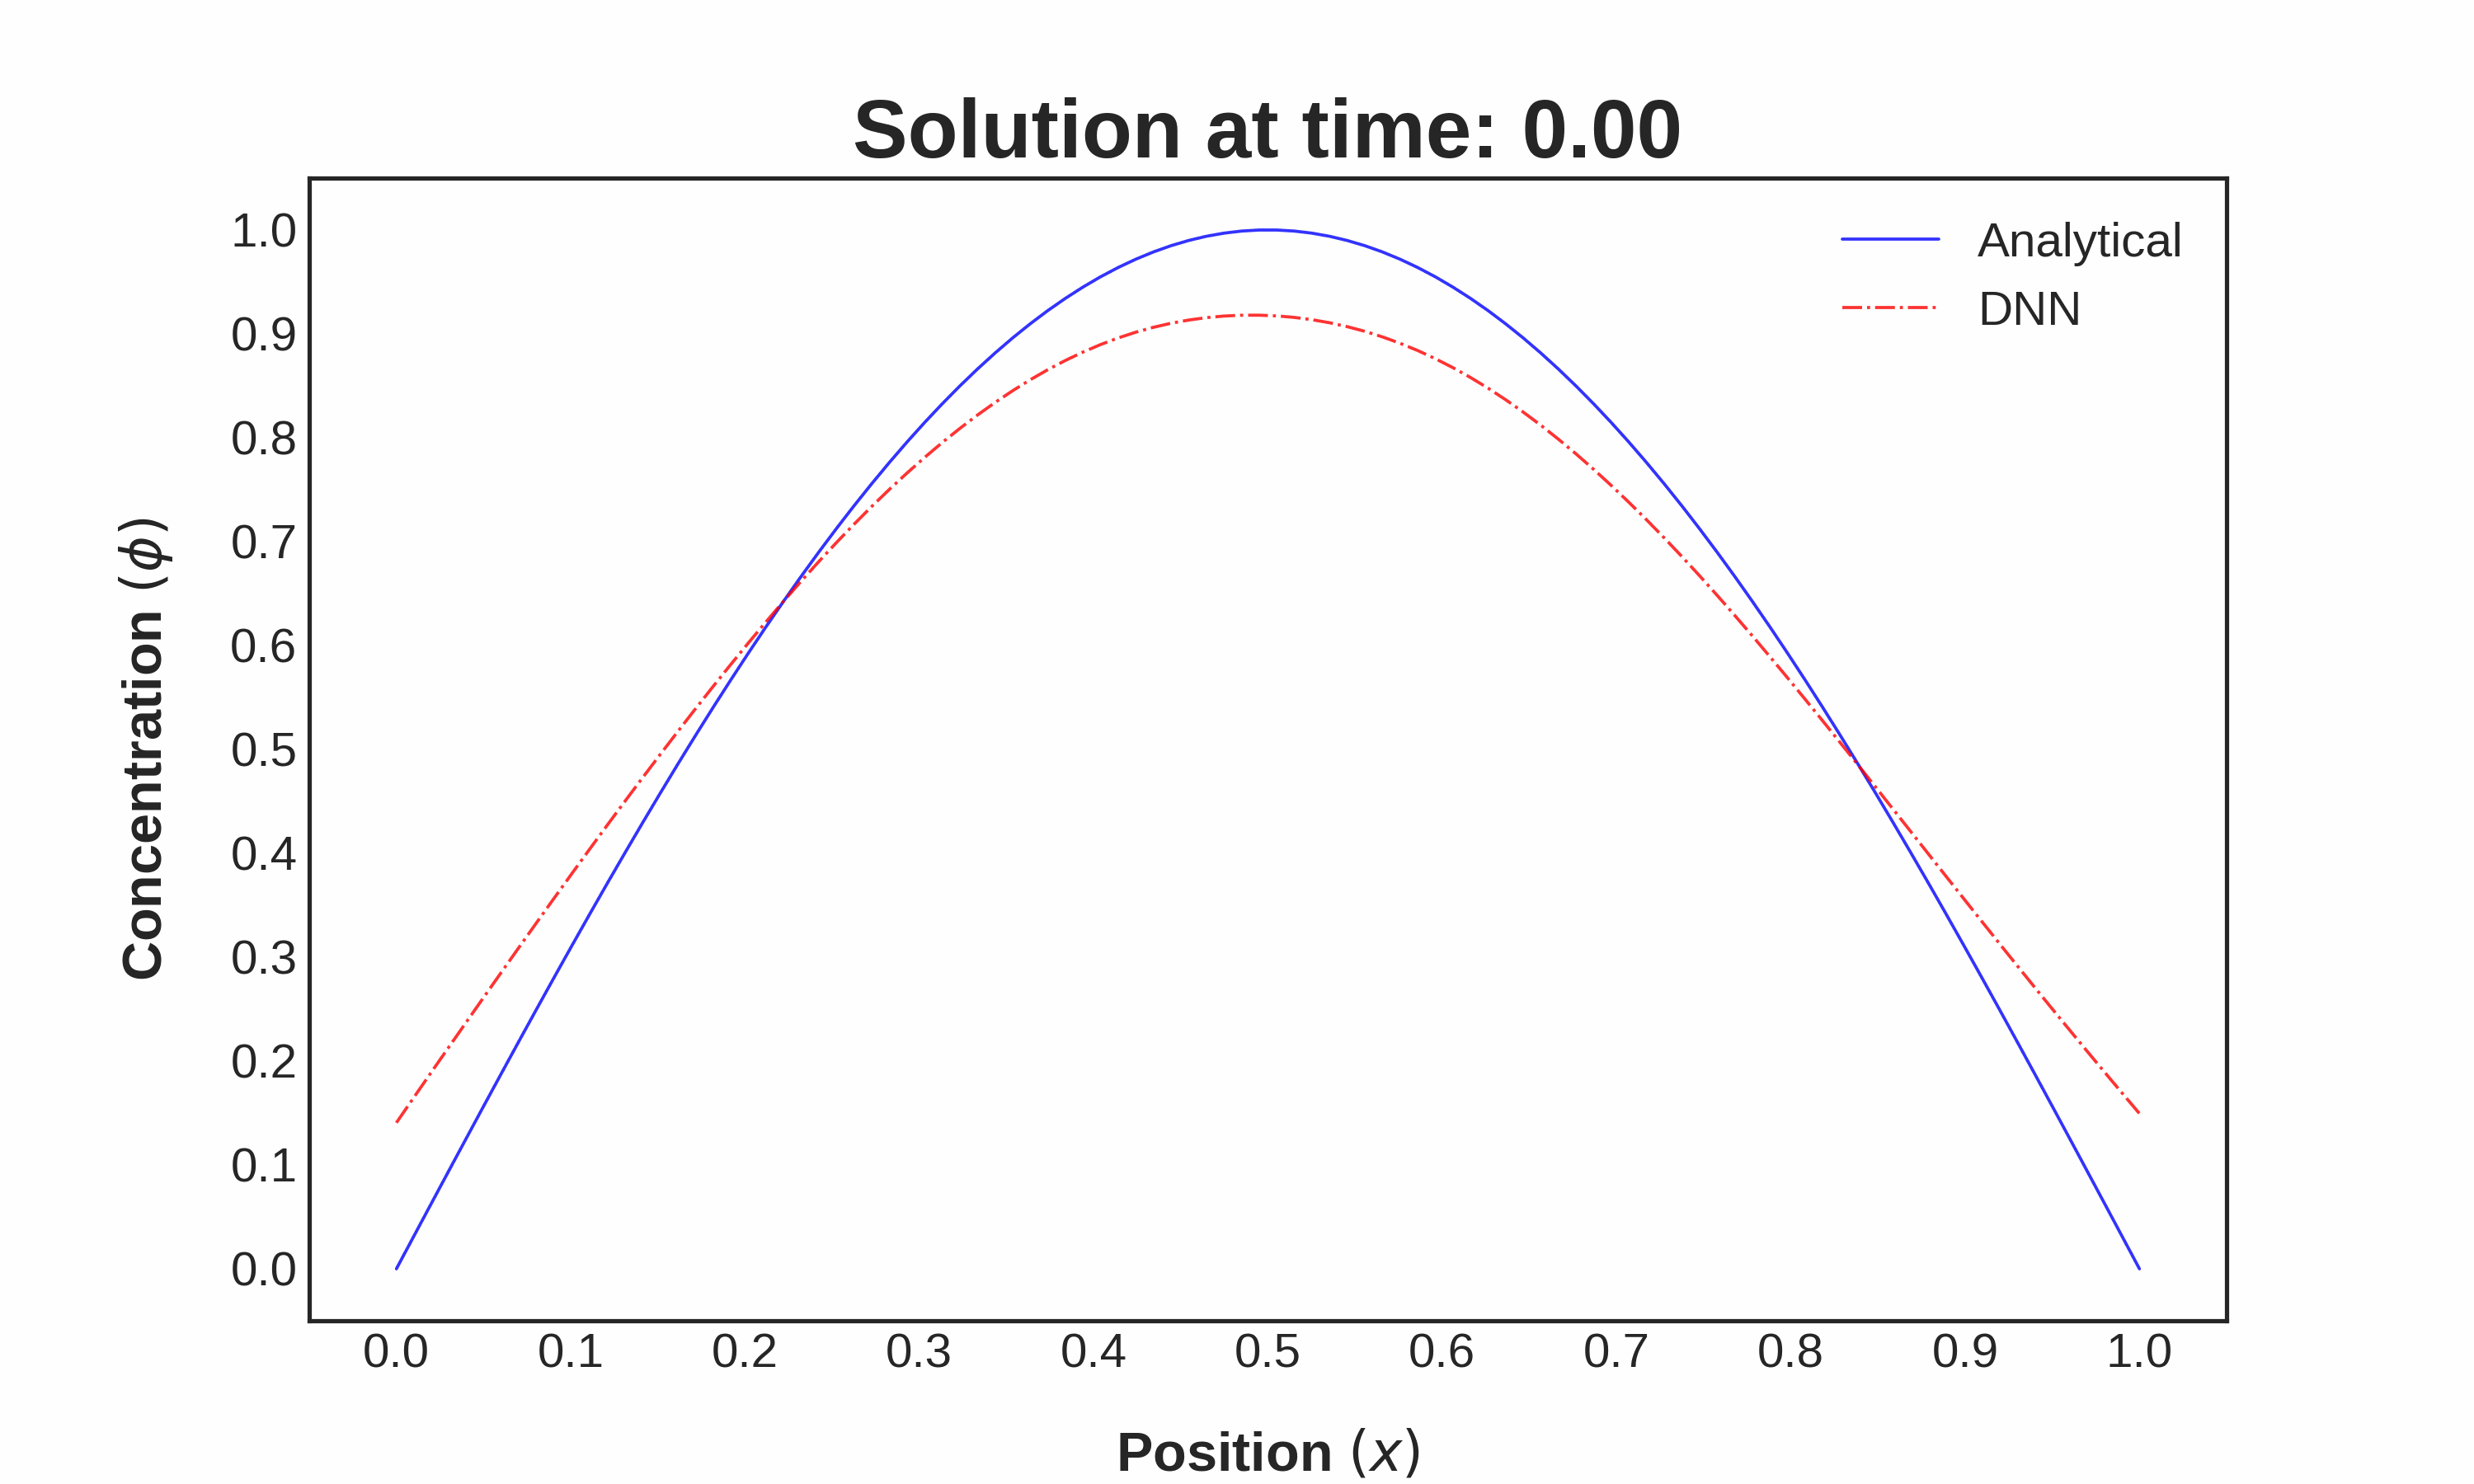

In [ ]:
from IPython.display import Image, display
display(Image(filename = my_dir+'diffusion_simulation.gif'))